# Analiza nogometnih tekem v top 3 ligah

## Uvod
Analiziral sem vse nogometne tekme sezone 2019/2020 v 3 najmočnejših nogometnih ligah: Premier league, LaLiga, Serie A. Podatke za vse tekme sem dobil na portalu [Transfermarkt](https://www.transfermarkt.com/). </p>

Za vsako odigrano tekmo v ligi sem zajel *podatke*:
* domačo in gostujočo ekipo
* končni rezultat tekme
* položaj domače in gostujoče ekipe na lestvici po odigrani tekmi
* čas tekme </p>

Ogledal in preveril sem naslednje *hipoteze*:

1. domača ekipa zmaga v več primerih kakor gostujoča
2. odstotek zmag domače ekipe je nižji po korona-premoru (prazne tribune)
3. forma ekipe vpliva na končni rezultat (večkrat zmaga ekipa, ki je v dobri formi kakor tista, ki je v slabi)
4. najpogostejši rezultat na derbijih (vodilne ekipe) je remi
5. boljše ekipe igrajo ob bolj poznih urah 
6. celotno število golov je najnižje v italjanski ligi (obrambni nogomet) in najvišje v španski ligi (napadalnejši nogomet) </p>

## Uvoz in obdelava

In [1]:
# Uvozimo vse knjižnice za delo

import pandas as pd

pd.options.mode.chained_assignment = None # Updatani pandas meče razne warninge, ki jih prej ni bilo. Našel to rešitev na stack-overflowu.

import matplotlib.pyplot as plt

In [2]:
# Uvozimo vse tabele

laliga = pd.read_csv('obdelani-podatki/laliga.csv')
premier_league = pd.read_csv('obdelani-podatki/premier_league.csv')
seriea = pd.read_csv('obdelani-podatki/seriea.csv')


# Dodamo stolpec držav v tabele
esp = len(laliga) * ['La Liga']
ita = len(laliga) * ['Serie A']
eng = len(laliga) * ['Premier League']

laliga['liga'] = esp
seriea['liga'] = ita
premier_league['liga'] = eng

In [3]:
# Pomožna funkcija za pretvorbo datuma v število
import re

vzorec_datuma = (
    r'(?P<mesec>\d{1,2})'
    r'/'
    r'(?P<dan>\d{1,2})'
    r'/'
    r'(?P<leto>\d{1,2})'
)

def izlusci_datum(dat):
    for datum in re.finditer(vzorec_datuma, dat):
        leto = datum['leto']
        mesec = datum['mesec']
        dan = datum['dan']
        return float(leto) + 1 / 12 * (float(mesec) - 1) + 1 / 12 * 1 / 31 * (float(dan) - 1)


# Vse tabele združimo v eno samo

lige = [laliga, premier_league, seriea]
league = pd.concat(lige)

league['datum_num'] = league.datum.apply(izlusci_datum)
league.index = range(len(league))

league

,kolo,dan,datum,ura,id_domaci,lestvica_domaci,domaca_ekipa,id_gostje,lestvica_gostje,gostujoca_ekipa,zadetki_domaci,tocke_domaci,zadetki_gostje,tocke_gostje,razlika_ekip,visja_na_lestvici,nizja_na_lestvici,remi,liga,datum_num
0,1,petek,8/16/19,9:00 PM,621,11,Athletic,131,2,FC Barcelona,1,3,0,0,9,2,11,0,La Liga,19.623656
1,1,sobota,8/17/19,5:00 PM,940,17,Celta de Vigo,418,1,Real Madrid,1,0,3,3,16,1,17,0,La Liga,19.626344
2,1,sobota,8/17/19,7:00 PM,1049,9,Valencia,681,7,Real Sociedad,1,1,1,1,2,7,9,1,La Liga,19.626344
3,1,sobota,8/17/19,8:00 PM,237,19,RCD Mallorca,1533,14,SD Eibar,2,3,1,0,5,14,19,0,La Liga,19.626344
4,1,sobota,8/17/19,9:00 PM,1244,18,CD Leganés,331,10,CA Osasuna,0,0,1,3,8,10,18,0,La Liga,19.626344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,38,nedelja,8/2/20,6:00 PM,2722,20,SPAL,430,10,Fiorentina,1,0,3,3,10,10,20,0,Serie A,20.586022
1136,38,nedelja,8/2/20,8:45 PM,252,17,Genoa,276,9,Hellas Verona,3,3,0,0,8,9,17,0,Serie A,20.586022
1137,38,nedelja,8/2/20,8:45 PM,1005,18,Lecce,130,11,Parma,3,0,4,3,7,11,18,0,Serie A,20.586022
1138,38,nedelja,8/2/20,8:45 PM,1025,12,Bologna,416,16,Torino,1,1,1,1,4,12,16,1,Serie A,20.586022


## Overjanje veljavnosti hipotez
### Hipoteza 1
Kot prvo hipotezo hočem pokazati, da domača ekipa zmaga v več primerih kot gostujoča.

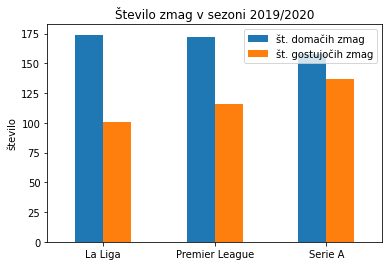

In [20]:
zmage_domacih = league[league.tocke_domaci > 1][['liga', 'tocke_domaci']]
zmage_gostov = league[league.tocke_domaci < 1][['liga', 'tocke_gostje']]

df1 = zmage_domacih.groupby('liga').count()
df2 = zmage_gostov.groupby('liga').count()

df = pd.concat([df1,df2], axis=1)
df = df.rename(columns={"tocke_domaci": "št. domačih zmag", "tocke_gostje": "št. gostujočih zmag"})

graf1 = df.plot.bar(rot=0) 
graf1.set(title='Število zmag v sezoni 2019/2020', ylabel='število', xlabel='');


V zgornjem grafu je jasno razvidno, da domače ekipe v vseh treh ligah zmagujejo večkrat kot gostujoče ekipe. Razlika je največja v španski La Ligi, precej majhna pa je v italijanski Serie A.<br> Hipoteza 1 je potrjena: **Domače ekipe zmagujejo bolj pogosto kot gostujoče.**

### Hipoteza 2
Možen vzrok hipoteze 1 je prisotnost navijačev, ki spodbujajo in pozitivno vplivajo na domačo ekipo. Tako želim z drugo hipotezo pokazati, da prisotnost navijačev res ugodno vpliva na končni rezultat domačih. Odstotek zmag domačih ekip po korona premoru bi se moral zmanjšati. Pred tem odmorom so namreč domače ekipe imele spodbudo navijačev na njihovih tekmah, po njem pa so zaradi korona-restrikcij tribune morale ostati prazne. <br>
<p> V Angliji se je odmor začel 4.1.2020 in končal 16.6.2020, v Italiji je trajal od 10.3.2020 do 21.6,2020, v Španiji pa od 4.1.2020 do 2.6.2020.

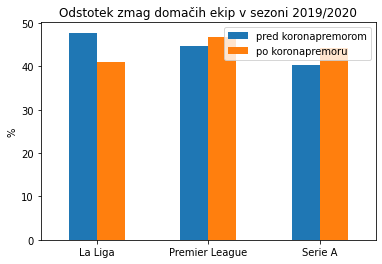

In [5]:
mejni_datum = izlusci_datum('3/15/20')

predkoronski = league[league.datum_num < mejni_datum][['liga', 'tocke_domaci']]
pokoronski = league[league.datum_num > mejni_datum][['liga', 'tocke_domaci']]

df1 = predkoronski.groupby('liga').count()
df1 = df1.rename(columns={"tocke_domaci": "allpred"})
df2 = pokoronski.groupby('liga').count()
df2 = df2.rename(columns={"tocke_domaci": "allpo"})

df3 = predkoronski[predkoronski.tocke_domaci > 1].groupby('liga').count()
df3 = df3.rename(columns={"tocke_domaci": "winpred"})
df4 = pokoronski[pokoronski.tocke_domaci > 1].groupby('liga').count()
df4 = df4.rename(columns={"tocke_domaci": "winpo"})

df = pd.concat([df1,df2,df3,df4], axis=1)
df['pred koronapremorom'] = df.winpred / df.allpred * 100
df['po koronapremoru'] = df.winpo / df.allpo * 100

graf2 = df[['pred koronapremorom', 'po koronapremoru']].plot.bar(rot=0) 
graf2.set(title='Odstotek zmag domačih ekip v sezoni 2019/2020', ylabel='%', xlabel='');

V zgodnjem grafu hipoteza nekako še drži za La Ligo, pri Premier League in Serie A pa jo lahko ovržemo. Odstotek zmag domačih ekip je bil namreč kljub odsotnosti navijačev v teh dveh ligah celo večji kot navadno. Razlog za to je najbrž dejstvo, da navijači niso vedno samo pozitivna okoliščina, temveč včasih tudi razlog za pritisk na igralcih. <br> </p>
Hipoteza 2 je zato ovržena: ** Odsotnost navijačev ne vpliva na možnosti domače ekipe za zmago. **

### Hipoteza 3
V hipotezi 3 me zanima, ali forma ekipe vpliva na končni rezultat (večkrat zmaga ekipa, ki je v dobri formi kakor tista, ki je v slabi).

In [6]:
# Napisati bo potrebno funkcijo, ki bo za vsako tekmo (od 5. kola naprej) pogledala, koliko točk je ekipa dobila iz prejšnjih 5 tekem
#Skladno s tem bomo pogledali odvisnost rezultata tekme od tega

def prejsnje_tekme(ekipa, krog):
    pts = 0
    if krog <= 5: return None
    else:
        for i in range(krog - 5,krog):
            if league[(league.kolo == i) & (league.domaca_ekipa == ekipa)].tocke_domaci.values.tolist() == []:
                pts += int(league[(league.kolo == i) & (league.gostujoca_ekipa == ekipa)].tocke_gostje.values.tolist()[0])
            else: pts += int(league[(league.kolo == i) & (league.domaca_ekipa == ekipa)].tocke_domaci.values.tolist()[0])
        return pts

#league['zgodovina_domaca'][6] = prejsnje_tekme(league.domaca_ekipa[6], int(league.kolo[6]))
league['forma_domaci'] = None
league['forma_gostje'] = None

for i in range(len(league)):
    league.forma_domaci[i] = prejsnje_tekme(league.domaca_ekipa[i], int(league.kolo[i]));
    league.forma_gostje[i] = prejsnje_tekme(league.gostujoca_ekipa[i], int(league.kolo[i]));

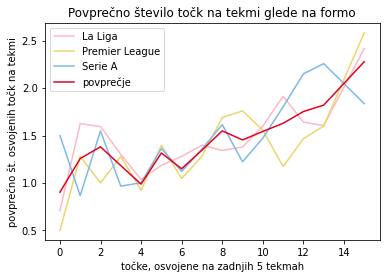

In [7]:
df1 = league[league.liga == 'La Liga'].groupby('forma_domaci')['tocke_domaci'].mean()
df2 = league[league.liga == 'La Liga'].groupby('forma_gostje')['tocke_gostje'].mean()
df3 = league[league.liga == 'Premier League'].groupby('forma_domaci')['tocke_domaci'].mean()
df4 = league[league.liga == 'Premier League'].groupby('forma_gostje')['tocke_gostje'].mean()
df5 = league[league.liga == 'Serie A'].groupby('forma_domaci')['tocke_domaci'].mean()
df6 = league[league.liga == 'Serie A'].groupby('forma_gostje')['tocke_gostje'].mean()
df7 = 1/2 * (df1 + df2)
df8 = 1/2 * (df3 + df4)
df9 = 1/2 * (df5 + df6)

df10 = 1/3 * (df7 + df8 + df9)


df = pd.concat([df7,df8,df9,df10],axis=1)
df = df.rename(columns={0: "La Liga", 1: "Premier League", 2: "Serie A", 3: "povprečje"})
df.index.name = 'forma'

df
graf3 = df[['La Liga', 'Premier League', 'Serie A', 'povprečje']].plot(color = ['#FFB7C5', '#E9D66B','#7CB9E8','#E30022'], rot=0)
graf3.set(title='Povprečno število točk na tekmi glede na formo', ylabel='povprečno št. osvojenih točk na tekmi', xlabel='točke, osvojene na zadnjih 5 tekmah');

Iz grafa je razvidno, da je končni izid tekme dejansko odvisen od forme ekipe. Odstopanja so predvsem na začetku. Razlog za to je verjetno v tem, da je forma relativen pojem in ni povsem ekvivalenten s številom osvojenih točk na zadnjih tekmah. Težko je na primer primerjati formi ekipe 1: (zmaga-zmaga-poraz-poraz-poraz) in ekipe 2: (remi-remi-remi-remi-remi). Čeprav je ekipa 1 zbrala več točk na zadnjih 5 tekmah (6 točk), ekipa 2 (5 točk) v istem obdobju sploh ni izgubila. V takih primerih je težko reči, katera od teh dveh ekip je dejansko v boljši formi. <br> </p>
Vseeno je krivulja dovolj "lepa", da lahko hipotezo 3 potrdimo: ** Izid tekme je odvisen od forme ekipe (oz. od osvojenih točk na zadnjih 5 tekmah). **

### Hipoteza 4
Hipoteza 4 trdi, da je najpogostejši rezultat na derbijih remi. To pomeni, da je število remijev na derbijih večje od števila zmag boljših ekip in števila zmag slabših ekip. </p> To hipotezo bom skušal dokazati tako, da bom primerjal verjetnost remija na tekmi glede na razliko položaja obeh ekip na ligaški lestvici. Beseda derbi v grobem pomenu predstavlja tekmo, kjer se merita ekipi, ki sta si na lestvici blizu.

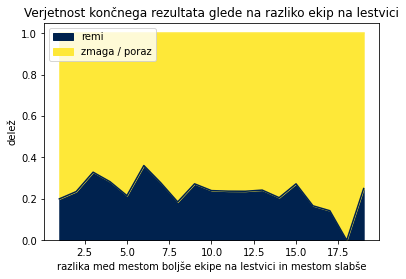

In [8]:
def zmaga(n):
    if n == 3: return 1
    else: return 0

league['zmaga_domaci'] = league.tocke_domaci.apply(zmaga)
league['zmaga_gostje'] = league.tocke_gostje.apply(zmaga)

pravicna = league[league.kolo >= 4].groupby('razlika_ekip').mean()[['zmaga_domaci', 'remi', 'zmaga_gostje']]
pravicna = pravicna.rename(columns={"zmaga_domaci": "zmaga domače ekipe", "zmaga_gostje": "zmaga gostujoče ekipe"})

def vsota(x):
    return x['zmaga domače ekipe'] + x['zmaga gostujoče ekipe']

samoremi = pravicna
samoremi['zmaga / poraz'] = None
samoremi['zmaga / poraz'] = samoremi.apply(vsota, axis=1)
samoremi = samoremi.drop(columns=['zmaga gostujoče ekipe', 'zmaga domače ekipe'])

graf4 = samoremi.plot.area(colormap='cividis')
graf4.set(title='Verjetnost končnega rezultata glede na razliko ekip na lestvici', ylabel='delež', xlabel='razlika med mestom boljše ekipe na lestvici in mestom slabše');
plt.legend(loc='upper left');

Zgornji graf nam sicer pokaže podatek o pogostosti remijev, ne pokaže pa podatka o tem, ali je zmagala boljša ali slabša ekipa. Iz njega ne moremo razbrati, kateri je najpogostejši izid derbija (zmaga boljše, remi, zmaga slabše ekipe). Zato je potrebno narediti še en podoben graf, ki bo prikazoval tudi to.

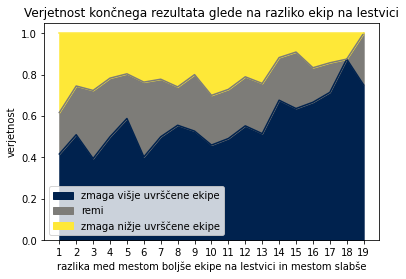

In [9]:
import numpy as np

def zmaga_boljse(x):
    if x['lestvica_domaci'] == min(x['lestvica_domaci'], x['lestvica_gostje']):
        if x['tocke_domaci'] == 3: return 1
        else: return 0
    else:
        if x['tocke_gostje'] == 3: return 1
        else: return 0

def zmaga_slabse(x):
    if x['remi'] == 0 and x['zmaga_boljse'] == 0: return 1
    else: return 0

league['zmaga_boljse'] = league.apply(zmaga_boljse, axis=1)
league['zmaga_slabse'] = league.apply(zmaga_slabse, axis=1)

pravicna = league[league.kolo >= 4].groupby('razlika_ekip').mean()[['zmaga_boljse', 'remi', 'zmaga_slabse']]
pravicna = pravicna.rename(columns={"zmaga_boljse": "zmaga višje uvrščene ekipe", "zmaga_slabse": "zmaga nižje uvrščene ekipe"})

graf5 = pravicna.plot.area(colormap='cividis')
graf5.set(title='Verjetnost končnega rezultata glede na razliko ekip na lestvici', ylabel='verjetnost', xlabel='razlika med mestom boljše ekipe na lestvici in mestom slabše');
plt.xticks(np.arange(1, 20, 1.0));

Zgornji graf za derbi predpostavlja tudi tekmo med 13. in 14. uvrščeno ekipo, pa čeprav to ni derbi v pravem nogometnem pomenu besede. Poglejmo si torej samo tiste tekme, kjer je boljša ekipa med prvimi šestimi v ligi. 

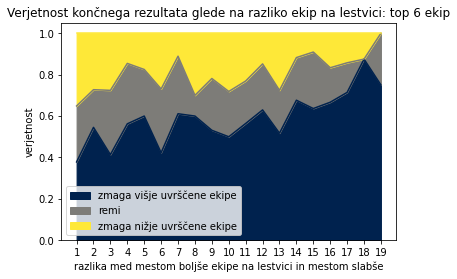

In [10]:
pravicna = league[(league.kolo >= 4) & (league.visja_na_lestvici <= 6)].groupby('razlika_ekip').mean()[['zmaga_boljse', 'remi', 'zmaga_slabse']]
pravicna = pravicna.rename(columns={"zmaga_boljse": "zmaga višje uvrščene ekipe", "zmaga_slabse": "zmaga nižje uvrščene ekipe"})

graf6 = pravicna.plot.area(colormap='cividis')
graf6.set(title='Verjetnost končnega rezultata glede na razliko ekip na lestvici: top 6 ekip', ylabel='verjetnost', xlabel='razlika med mestom boljše ekipe na lestvici in mestom slabše');
plt.xticks(np.arange(1, 20, 1.0));

Na podlagi zgornjega grafa je dobro vidno, da je remi sicer na derbijih bolj verjeten kakor na tekmi z večjo razliko med boljšo in slabšo ekipo, vendar ni niti blizu tega, da bi bil to najbolj pogost rezultat. Boljša ekipa tudi na derbijih zabeleži več zmag kakor remijev. Hipoteza 4 je torej ovržena: ** Najpogostejši izid na derbijih ni remi. **

### Hipoteza 5
Boljše ekipe igrajo ob bolj poznih urah.

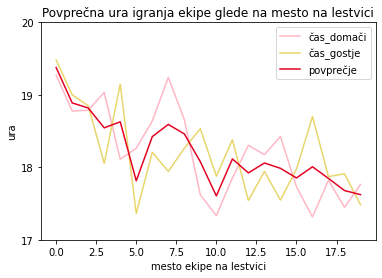

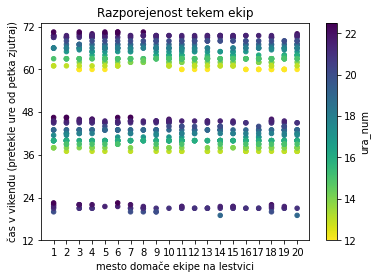

In [11]:
vzorec_ure = (
    r'(?P<ura>\d{1,2})'
    r':'
    r'(?P<minuta>\d{1,2})'
    r' '
    r'(?P<tip>\w{2})'
)

def PM_AM(a):
    if a == "AM": return 0
    else: return 1/2

def izlusci_uro(casi):
    for cas in re.finditer(vzorec_ure, casi):
            ura = cas['ura']
            minuta = cas['minuta']
            dodano = cas['tip']
            if (int(ura) == 12): return 24 * (1/12 * (1 / 60 * float(minuta)) + float(PM_AM(dodano)))
            else: return 24 * (1/24 * (float(ura)) + 1/12 * (1 / 60 * float(minuta)) + float(PM_AM(dodano)))

def izlusci_vikend(dan):
    if dan == 'petek': return 0
    elif dan == 'sobota': return 24
    elif dan == 'nedelja': return 48
    else: return None

league['ura_num'] = league.ura.apply(izlusci_uro)
league['dan_num'] = league.dan.apply(izlusci_vikend)

def vikend(x): 
    return x['ura_num'] + x['dan_num']

league['vikend'] = league.apply(vikend, axis=1)

df1 = league.groupby('lestvica_domaci').mean()['ura_num'].to_frame().reset_index()
df2 = league.groupby('lestvica_gostje').mean()['ura_num'].to_frame().reset_index()

df1.columns=['lestvica', 'čas_domači']
df2.columns=['lestvica', 'čas_gostje']

df = pd.merge(df1, df2, on='lestvica')

def povprecje(x):
    return 1/2 * (x['čas_domači'] + x['čas_gostje'])

df['povprečje'] = None
df['povprečje'] = df.apply(povprecje, axis=1)

graf7= df[['čas_domači', 'čas_gostje', 'povprečje']].plot(color = ['#FFB7C5', '#E9D66B', '#E30022'], rot=0)
graf7.set(title='Povprečna ura igranja ekipe glede na mesto na lestvici', ylabel='ura', xlabel='mesto ekipe na lestvici');
plt.yticks(np.arange(17, 21, 1.0));

fig, ax = plt.subplots();
graf9 = league[league.dan_num != None].plot.scatter(x='lestvica_domaci', y='vikend', c='ura_num', colormap='viridis_r', ax=ax)
graf9.set(title='Razporejenost tekem ekip', ylabel='čas v vikendu (pretekle ure od petka zjutraj)', xlabel='mesto domače ekipe na lestvici');
plt.xticks(np.arange(1, 21, 1.0));
plt.yticks(np.arange(12, 73, 12));

Zgornji 'scatterplot' še vedno ne prikazuje pravilne gostote, saj ne moremo dobro videti, kje so pike gosto skupaj. Rešitev je, da čas igranja grupiramo na zgodaj popoldne (pred 15h), popoldne (15h-18h), pozno popoldne (18h-20h) in zvečer (po 20h).

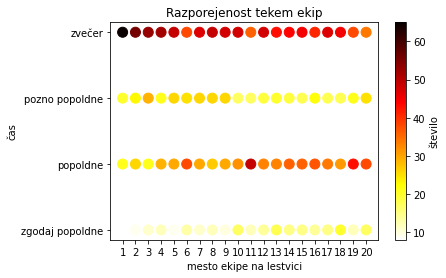

In [12]:
def opisi_cas(flt):
    if flt < 15:
        return 'zgodaj popoldne'
    elif flt < 18:
        return 'popoldne'
    elif flt < 20:
        return 'pozno popoldne'
    else: return 'zvečer'

league['opisni_cas'] = None;
league.opisni_cas = league.ura_num.apply(opisi_cas);

df1 = league.groupby(['lestvica_domaci', 'opisni_cas']).count()['kolo'].to_frame()
df2 = league.groupby(['lestvica_gostje', 'opisni_cas']).count()['kolo'].to_frame()

df1 = df1.reset_index()
df2 = df2.reset_index()

df1.columns=['lestvica', 'čas', 'število']
df2.columns=['lestvica', 'čas', 'število']

df = pd.concat([df1, df2]).reset_index()
df = df.groupby(['lestvica', 'čas'], as_index = False).sum().drop(columns='index')

order = ['zgodaj popoldne', 'popoldne', 'pozno popoldne', 'zvečer']
df['čas'] = pd.Categorical(df['čas'], order)
df.sort_values(by=['čas'], inplace=True)


fig, ax = plt.subplots();
graf12 = df.plot.scatter(x='lestvica', y='čas', s=100, c='število', colormap='hot_r', ax=ax)
graf12.set(title='Razporejenost tekem ekip', ylabel='čas', xlabel='mesto ekipe na lestvici');
plt.xticks(np.arange(1, 21, 1.0));

Kot lahko vidimo na prvih dveh grafih zgoraj, mesto ekipe na lestvici nekako vpliva na igralno uro. Ker pa je realnost takšna, da se urnike sestavlja že pred sezono to ne velja vedno (ne ve se v naprej katero moštvo bo boljše oz. slabše, odvisno je predvsem od predvidevanja). V grobem pa vseeno lahko vidimo, da višje kot je ekipa na lestvici, bolj pozno ponavadi igra. Še bolje se to vidi v najbolj spodnjem 'scatterplotu', kjer vidimo da boljše ekipe igrajo skoraj vedno zvečer. Hipoteza 5 je torej potrjena: ** Boljše ekipe v povprečju igrajo bolj pozno, največkrat v večernem terminu. ** <br> </p>
Iz predzadnjega grafa lahko preberemo še, da se v petkih ponavadi igra samo zvečer.


### Hipoteza 6
V hipotezi 6 bomo preverjali povprečno število golov na tekmo v ligah. Želim pokazati, da je španski nogomet najbolj "odprt" (tj. pade največ zadetkov na tekmo), italijanski pa najmanj "odprt" (ni veliko zadetkov).

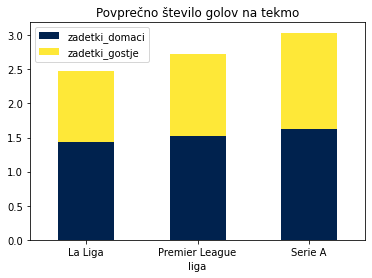

In [13]:
goli = league.groupby('liga').mean()[['zadetki_domaci','zadetki_gostje']]

graf10 = goli.plot.bar(rot=0, stacked=True, colormap='cividis') 
graf10.set(title='Povprečno število golov na tekmo');

Hipotezo 6 lahko ovržemo, saj se je izkazalo ravno nasprotno: ** Največ golov pade v italijanski Serie A, najmanj pa v španski La Ligi. **

## Zanimivost

S pomočjo *naivnega Bayesovega klasifikatorja* bom pogledal, katere črke imajo v imenu dobri klubi in katere imajo slabi. </p>

Zanimalo nas bo:
> P (mesto na lestvici | ime ekipe (črke uporabljene v imenu))

In [14]:
# Naredimo novo tabelo v kateri bodo ekipe in njihov končni položaj na lestvici
domace = league[league.kolo == 38]
domace['ekipa'] = domace['domaca_ekipa']
domace['lestvica'] = domace['lestvica_domaci']
domace = domace[['ekipa', 'lestvica']]

gostujoce = league[league.kolo == 38]
gostujoce['ekipa'] = gostujoce['gostujoca_ekipa']
gostujoce['lestvica'] = gostujoce['lestvica_gostje']
gostujoce = gostujoce[['ekipa', 'lestvica']]


bayes = pd.merge(domace, gostujoce, how='outer').sort_values('lestvica')[['ekipa', 'lestvica']]
bayes['ime_ekipe'] = bayes['ekipa']
bayes = bayes.set_index('ekipa')

In [15]:
def crke(niz):
    seznam = []
    for crka in niz:
        if (crka in seznam): continue # Da se črke ne ponavljajo
        elif crka == " ": seznam.append(" ")
        else: seznam.append(crka.lower())
    return pd.Series(seznam)

crke_ekip = bayes.ime_ekipe.apply(crke).stack().reset_index(level='ekipa').rename(columns={'ekipa': 'ime_ekipe', 0: 'crke'})

crke_in_vrednosti = pd.merge(crke_ekip, bayes.lestvica, left_on='ime_ekipe', right_on='ekipa')[['ime_ekipe', 'lestvica', 'crke']]


# Tukaj dodamo še črke, ki jih ni v imenih ekip
def dodajcrko(crka, df):
    df = df.append({
        'ime_ekipe': 'Crka',
        'lestvica': 21,
        'crke': crka
    }, ignore_index=True)
    return df

mankajoce_crke = ['č', 'š', 'đ', 'ž', 'ć', 'k', 'x', 'q']

for element in mankajoce_crke:
    crke_in_vrednosti = dodajcrko(element, crke_in_vrednosti)

In [16]:
crke_in_verjetnosti = pd.crosstab(crke_in_vrednosti.crke, crke_in_vrednosti.lestvica)

crke_in_verjetnosti = crke_in_verjetnosti.drop(columns=21)

def neverjetnost(num): # Za 10% povečamo, kjer je P(crka|mesto) = 0
    if num == 0: return 0.1
    else: return num

crke_in_verjetnosti = (crke_in_verjetnosti / 3)

crke_in_verjetnosti = crke_in_verjetnosti.applymap(neverjetnost)

crke_in_verjetnosti['total'] = None
crke_in_verjetnosti['total'] = 3 * crke_in_verjetnosti.sum(axis=1)


# Ta tabela nam pove P(ekipa ima v imenu crko | ekipa zaseda mesto na lestvici)


In [17]:
# Tukaj apliciramo Bayesov obrazec

# Naša formula se glasi:
# P(ekipa zasede i-to mesto | ekipa vsebuje črke x_j, j=1,2,...,k) = 1/20 * Produkt(P(ekipa vsebuje črko x_j | ekipa zaseda i-to mesto)) / Produkt(P(ekipa vsebuje črke x_j))

def razlicnih_crk(niz):
    seznam = []
    for crka in niz:
        if crka in seznam: continue
        else: seznam.append(crka)
    return len(seznam)


def doloci_verjetnosti(ime, mesto):
    seznam = []
    imenovalec = 1/20 # Začetni koeficient v formuli, ki predstavlja P(ekipa zasede mesto "mesto")
    stevec = 1 # Spodnji del ulomka
    vsecrke = crke_in_verjetnosti['total'].sum()  # Število vseh črk v ekipah
    razlicnih = razlicnih_crk(ime)
    for crka in ime:
        if crka in seznam: continue # Vsako črko iz imena ekipe se pogleda samo enkrat
        else:
            imenovalec = imenovalec * crke_in_verjetnosti[mesto][crka.lower()]
            stevec = stevec * (crke_in_verjetnosti['total'][crka.lower()] / 60) # 60 je namreč vseh opazovanih ekip
            seznam.append(crka)
            razlicnih -= 1
    return imenovalec / stevec


from pandas import DataFrame

def df(ime_ekipe):
    seznam = []
    for i in range(1,21):
        zacasni = []
        zacasni.append(i)
        zacasni.append(doloci_verjetnosti(ime_ekipe, i))
        seznam.append(zacasni)
    return DataFrame(seznam, columns=['mesto','verjetnost']).set_index('mesto')

def upanje(ime_ekipe):
    e = 0
    for i in range(1, 21):
        e += i * doloci_verjetnosti(ime_ekipe, i)
    return e

Ime = NK Bovec
Povprečna uvrstitev: 12. mesto


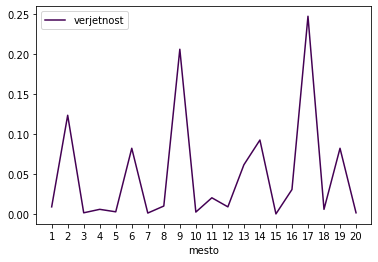

In [18]:
ime = 'NK Bovec'
grafBovec = df(ime).plot(colormap='viridis')
plt.xticks(np.arange(1, 21, 1.0))

print('Ime = ' + ime)
print('Povprečna uvrstitev: ' + str(int(round(upanje(ime), 0))) + '. mesto')

Ime = FC Tolmin
Povprečna uvrstitev: 6. mesto


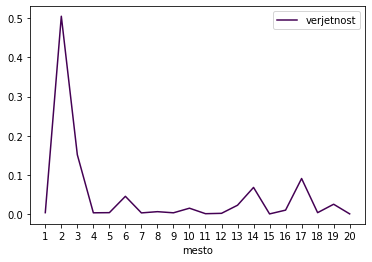

In [19]:
ime = 'FC Tolmin'
grafBovec = df(ime).plot(colormap='viridis')
plt.xticks(np.arange(1, 21, 1.0))   

print('Ime = ' + ime)
print('Povprečna uvrstitev: ' + str(int(round(upanje(ime), 0))) + '. mesto')

Kot vidimo s pomočjo Bayesovega obrazca, bi bilo ime "NK Bovec" precej slabo za nogometni klub, saj bi po našem algoritmu povprečno zasedel 12. mesto med 20 ekipami. Boljše ime bi bilo "FC Tolmin", povprečno bi bili 6.

Naj poudarim, da v praksi ime ekipe nima povezave z uspešnostjo, razlike nastanejo predvsem zaradi majhnega vzorca (samo 60 klubov). Algoritem je bil narejen bolj za zabavo.

# Zaključek

Glede mojih hipotez sem ugotovil:

* domača ekipa zmaga v več primerih kakor gostujoča
* odstotek zmag domače ekipe **ni** nižji po korona-premoru (prazne tribune)
* forma ekipe vpliva na končni rezultat (večkrat zmaga ekipa, ki je v dobri formi kakor tista, ki je v slabi)
* najpogostejši rezultat na derbijih (vodilne ekipe) **ni** remi
* boljše ekipe igrajo ob bolj poznih urah 
* celotno število golov **ni** najnižje v italjanski ligi (obrambni nogomet) in **ni** najvišje v španski ligi (precej napadalen nogomet)